# Build Structural Topic Model on NEH Grant Products

<b>Author:</b> Jaren Haber, PhD <br>
<b>Date</b>: September 16, 2023 <br>
<b>Description</b>: Preprocesses text, estimates structural topic model, and assesses output of topic/term/gender relationships with emphasis on visualizations. <br>
<b>Sources</b>: Code snippets and inspiration borrowed from [my team's work here](https://github.com/comp-strat/text_analysis/tree/master/topic_modeling) and [this vignette for STM in R](https://cran.r-project.org/web/packages/stm/vignettes/stmVignette.pdf) <br>
<b>Required packages</b> (to install): `stm`, `texteffect`, `quanteda`, `tm`, `Rtsne`, `rsvd`, `geometry`, `wordcloud` <br>

## Initialize

In [1]:
install.packages(c("pacman"))

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [29]:
# import libraries -- can simplify to above list if too slow/demanding on memory
pacman::p_load(
    foreign,
    ggplot2,
    tidyr,
    dplyr,
    tm, 
    furrr,
    wordcloud, 
    tidytext, # for tidy text
    tidyverse, 
    stm, # for structural topic modeling
    stmCorrViz, 
    LDAvis, 
    igraph, 
    stringr, 
    quanteda, 
    zoo, 
    tau, 
    knitr, 
    rsvd, 
    magrittr,
    broom, 
    lubridate,
    repr)

In [30]:
# Set universal plot size
options(repr.plot.width=10, repr.plot.height=8, repr.plot.res = 300)

# Set working directory to data folder
setwd('../data/')
getwd()

[1] "/home/jovyan/work/neh-nlp/data"

## Import data

In [4]:
data = read.csv('NEH_GrantProducts_Prepared_w_Gender.tsv', sep='\t')
str(data)

'data.frame':	7108 obs. of  5 variables:
 $ ID         : int  8 21 22 24 29 38 39 45 46 47 ...
 $ Abstract   : chr  "Parallel vetted publication of the NEH sponsored project \"Visualizing Statues in the Late Antique Roman Forum\"" "This comparative study of late nineteenth century Britain and France examines regional and local patterns of ru"| __truncated__ "This comparative spatial history combines historical narrative, geographical thinking, and spatial analysis of "| __truncated__ "One of the early drivers of historical GIS was the development of national historical GISs. These systems usual"| __truncated__ ...
 $ Year       : int  2011 2010 2011 2009 2010 2010 2011 2005 2004 2004 ...
 $ ProductType: chr  "Articles" "Articles" "Articles" "Articles" ...
 $ Male       : num  1 1 1 1 0 0 0 1 0 1 ...


In [5]:
# check whether rows contain any NAs
row.has.na <- apply(data, 1, function(x){any(is.na(x))})
sum(row.has.na)

[1] 0

## Prepare text data

In [6]:
processed <- textProcessor(data$Abstract, metadata = data)

Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 


In [7]:
processed

A text corpus with 7098 documents, and an 31291 word dictionary.

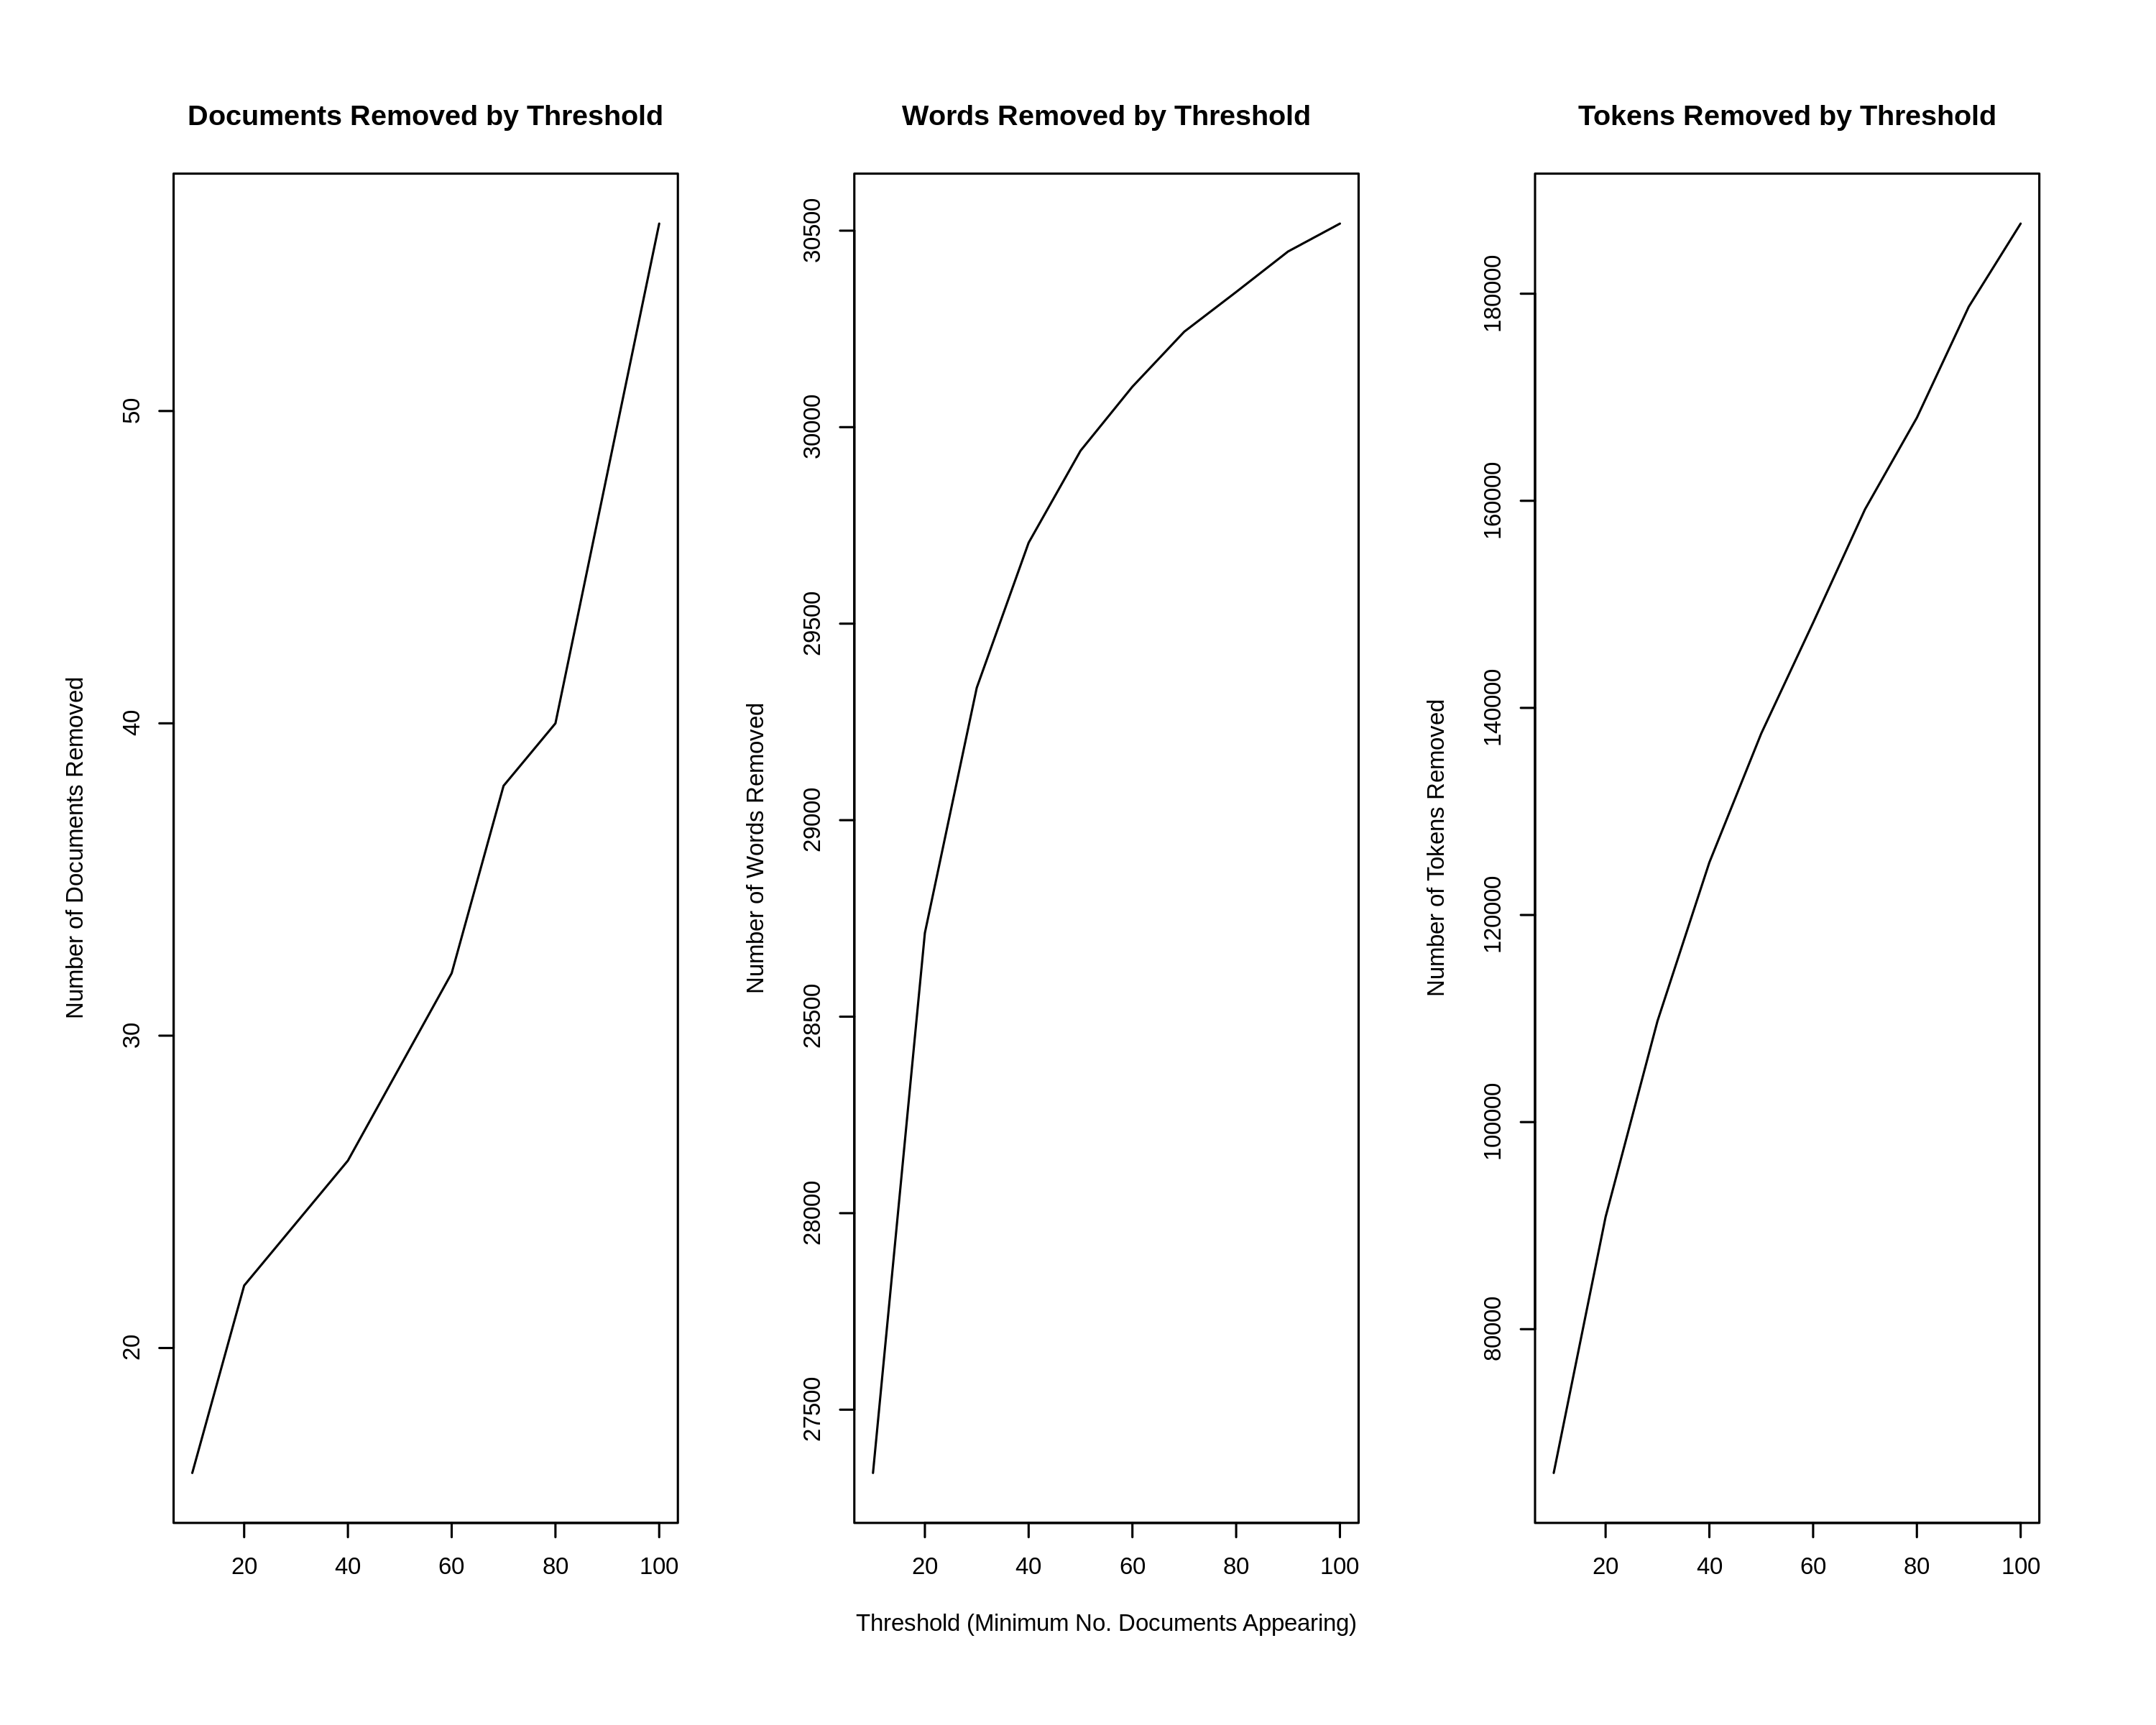

In [31]:
plotRemoved(processed$documents, lower.thresh = seq(10, 100, by = 10))

In [9]:
out <- prepDocuments(processed$documents, processed$vocab, processed$meta, lower.thresh = 3)

Removing 23504 of 31291 terms (31397 of 361677 tokens) due to frequency 
Removing 12 Documents with No Words 
Your corpus now has 7086 documents, 7787 terms and 330280 tokens.

In [10]:
docs <- out$documents
vocab <- out$vocab
meta <- out$meta

## Estimate Structural Topic Model

In [11]:
model <- stm(documents = out$documents, 
             vocab = out$vocab, 
             K = 20, 
             prevalence =~ Year + Male, 
             max.em.its = 25, 
             data = out$meta, 
             init.type = "Spectral")

Beginning Spectral Initialization 
	 Calculating the gram matrix...
	 Finding anchor words...
 	....................
	 Recovering initialization...
 	.............................................................................
Initialization complete.
.....................................................................................................
Completed E-Step (2 seconds). 
Completed M-Step. 
Completing Iteration 1 (approx. per word bound = -7.781) 
.....................................................................................................
Completed E-Step (2 seconds). 
Completed M-Step. 
Completing Iteration 2 (approx. per word bound = -7.576, relative change = 2.632e-02) 
.....................................................................................................
Completed E-Step (2 seconds). 
Completed M-Step. 
Completing Iteration 3 (approx. per word bound = -7.466, relative change = 1.453e-02) 
...........................................................

In [12]:
# Save model to disk
save(model, file='../output/topic_model_k20.RData')

## Examine words and example documents

In [13]:
# 20 topics
# Shows the top 50 words for each topic according to Highest, FREX, Lift, and Score measures with Frex =.7
top_words <- labelTopics(model, n=30, frexweight = .7)
top_words

Topic 1 Top Words:
 	 Highest Prob: languag, archaeolog, use, site, data, result, word, excav, linguist, analysi, present, paper, ancient, includ, structur, architectur, relat, system, also, can, studi, survey, method, featur, evid, one, find, locat, may, provid 
 	 FREX: archaeolog, languag, linguist, dictionari, excav, site, survey, audio, word, coptic, speaker, data, architectur, corpus, result, structur, grammar, morpholog, locat, spoken, method, type, encod, compar, entri, tag, typolog, season, artifact, system 
 	 Lift: amith, edfu, epipalaeolith, faunal, fortif, klallam, lidar, methon, morphosyntact, nahuatl, quechuan, suffix, totonac, yauyo, encycloped, kharaneh, mesolex, phonolog, saanich, hup, small-scal, lifeway, azoria, prosod, uto-aztecan, sinop, hut, morpholog, self-guid, cahto 
 	 Score: archaeolog, languag, encycloped, excav, dictionari, morpholog, data, site, coptic, linguist, tag, audio, hunter-gather, evidenti, ancient, sinop, verb, lexic, kierkegaard, grammat, cahto

## Visualize STM

png 
  2

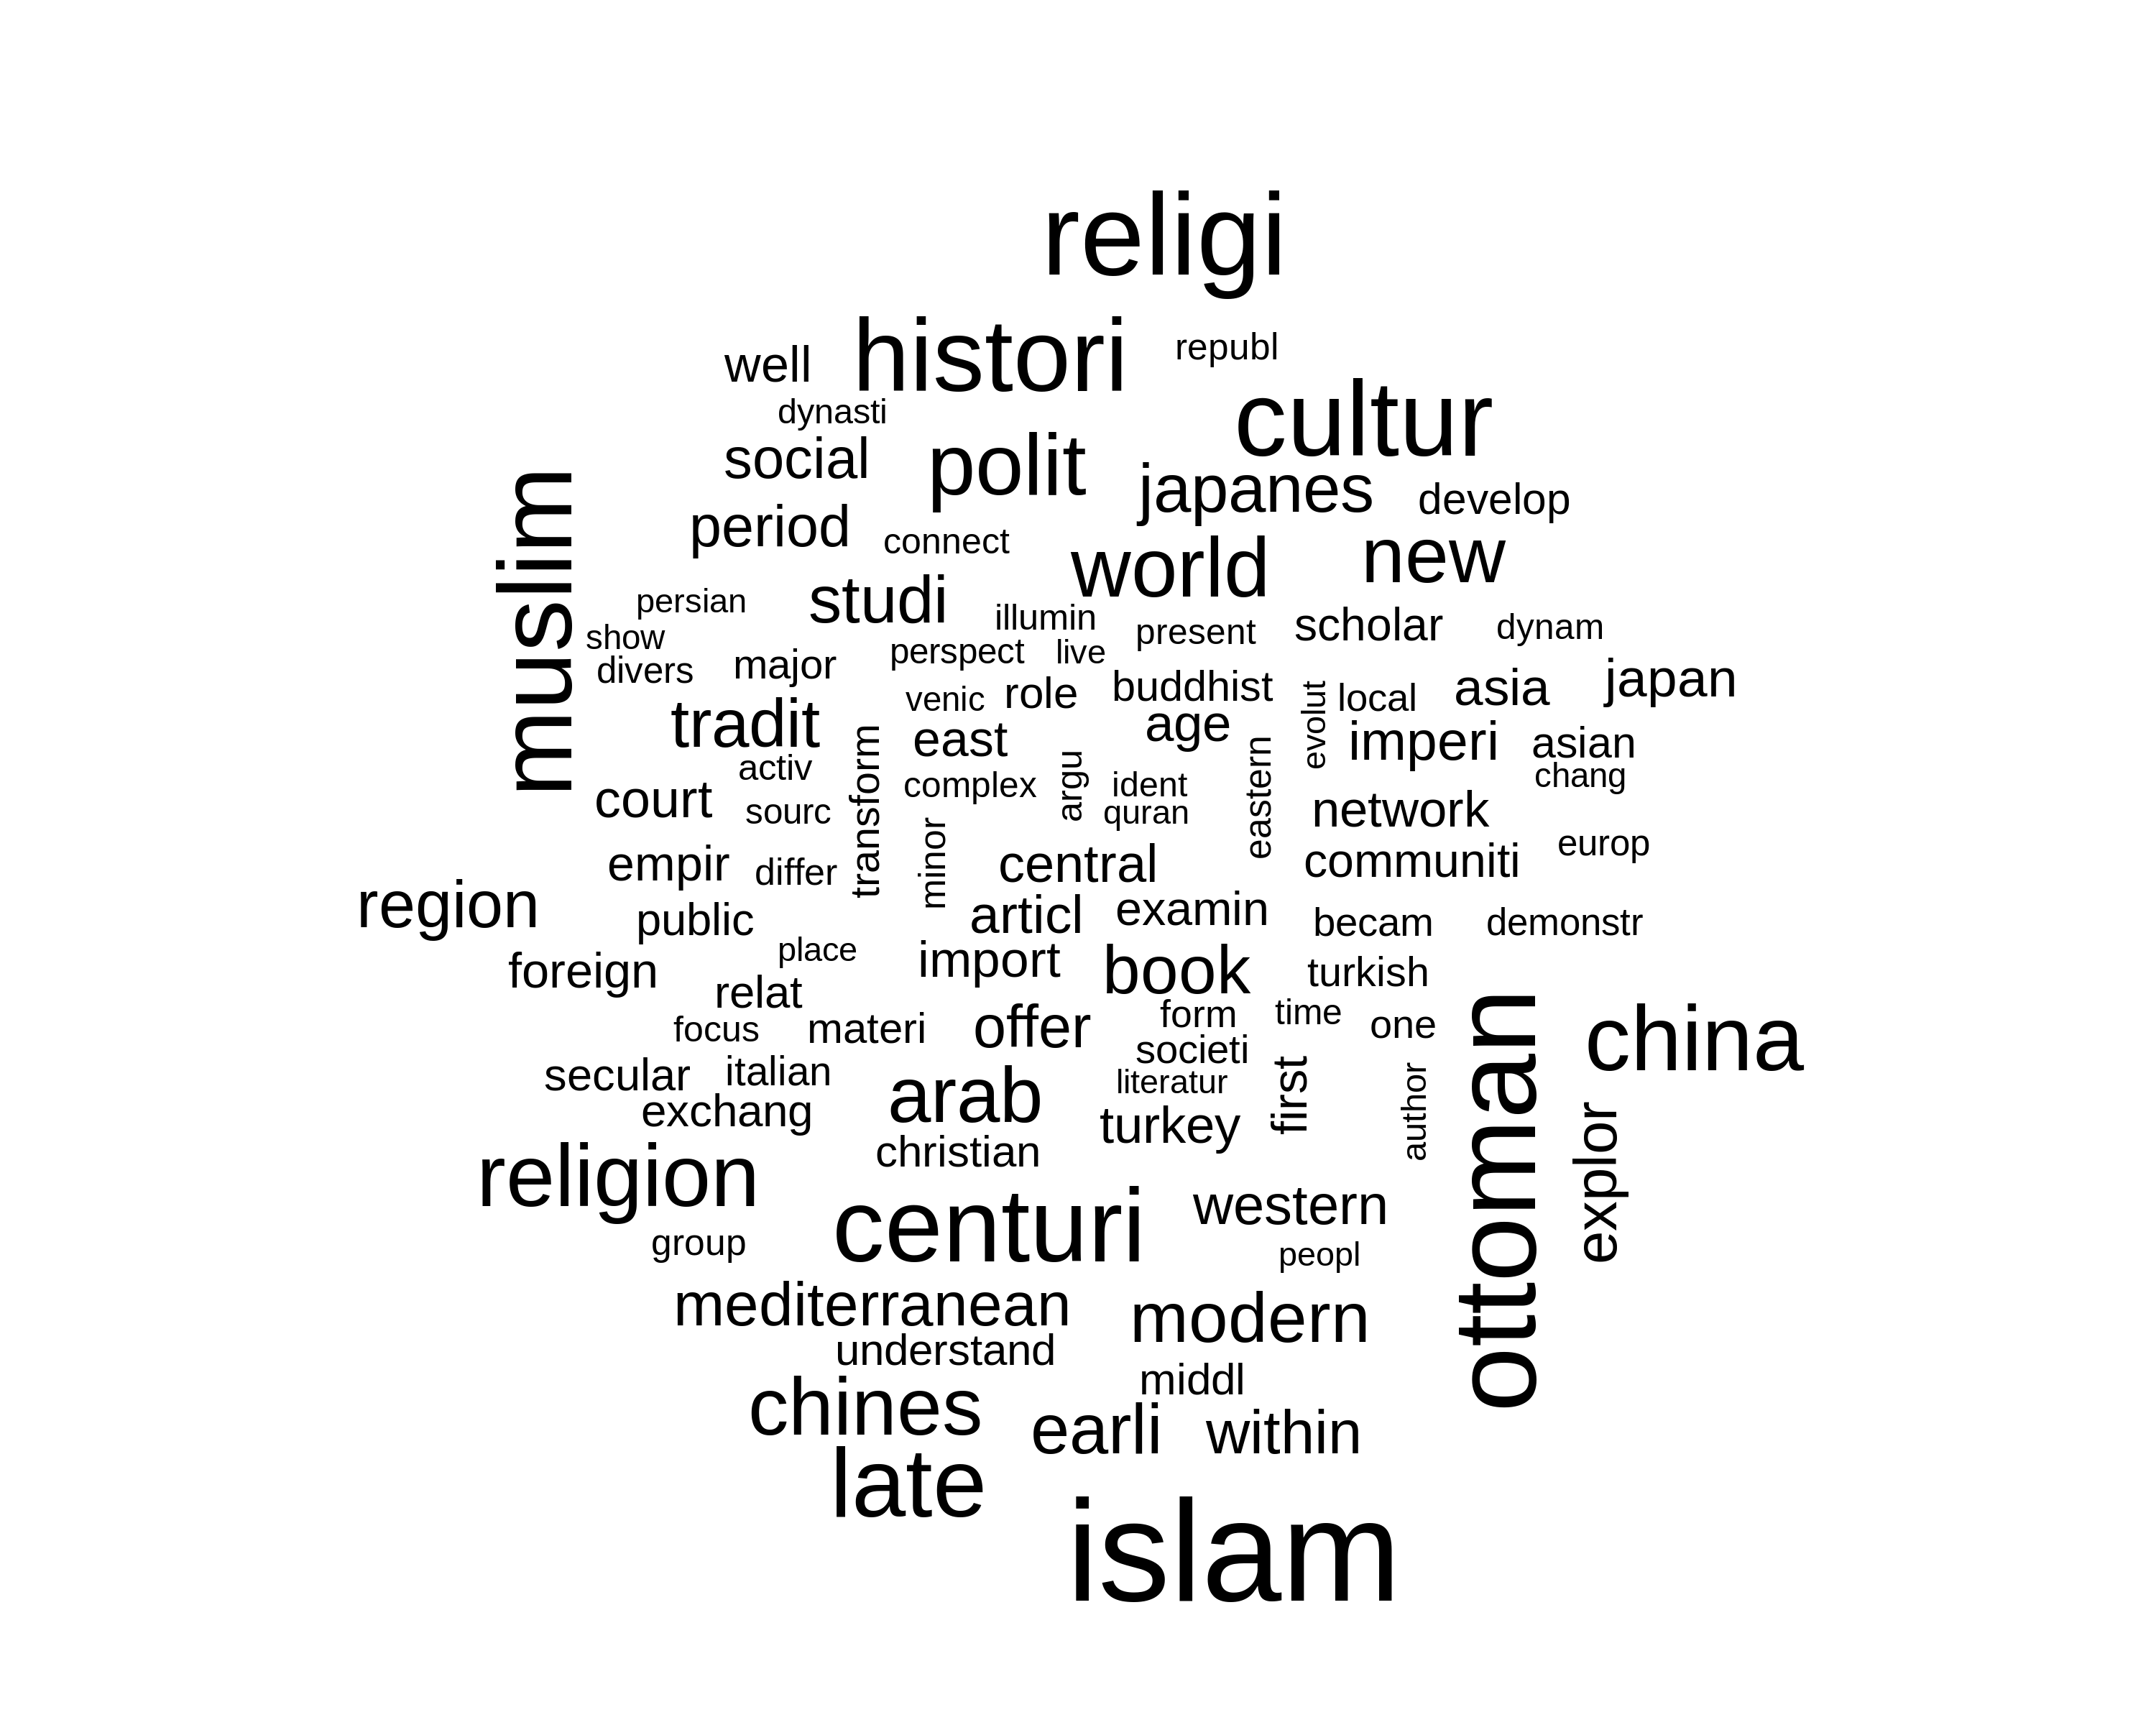

In [41]:
# Make word cloud of all the (stemmed) terms in corpus
png(filename='../output/wordcloud.png', width = 1700, height = 1700, units = "px", res = 300)
cloud(model, 19, documents=docs)
dev.off()

cloud(model, 19, documents=docs)

png 
  2

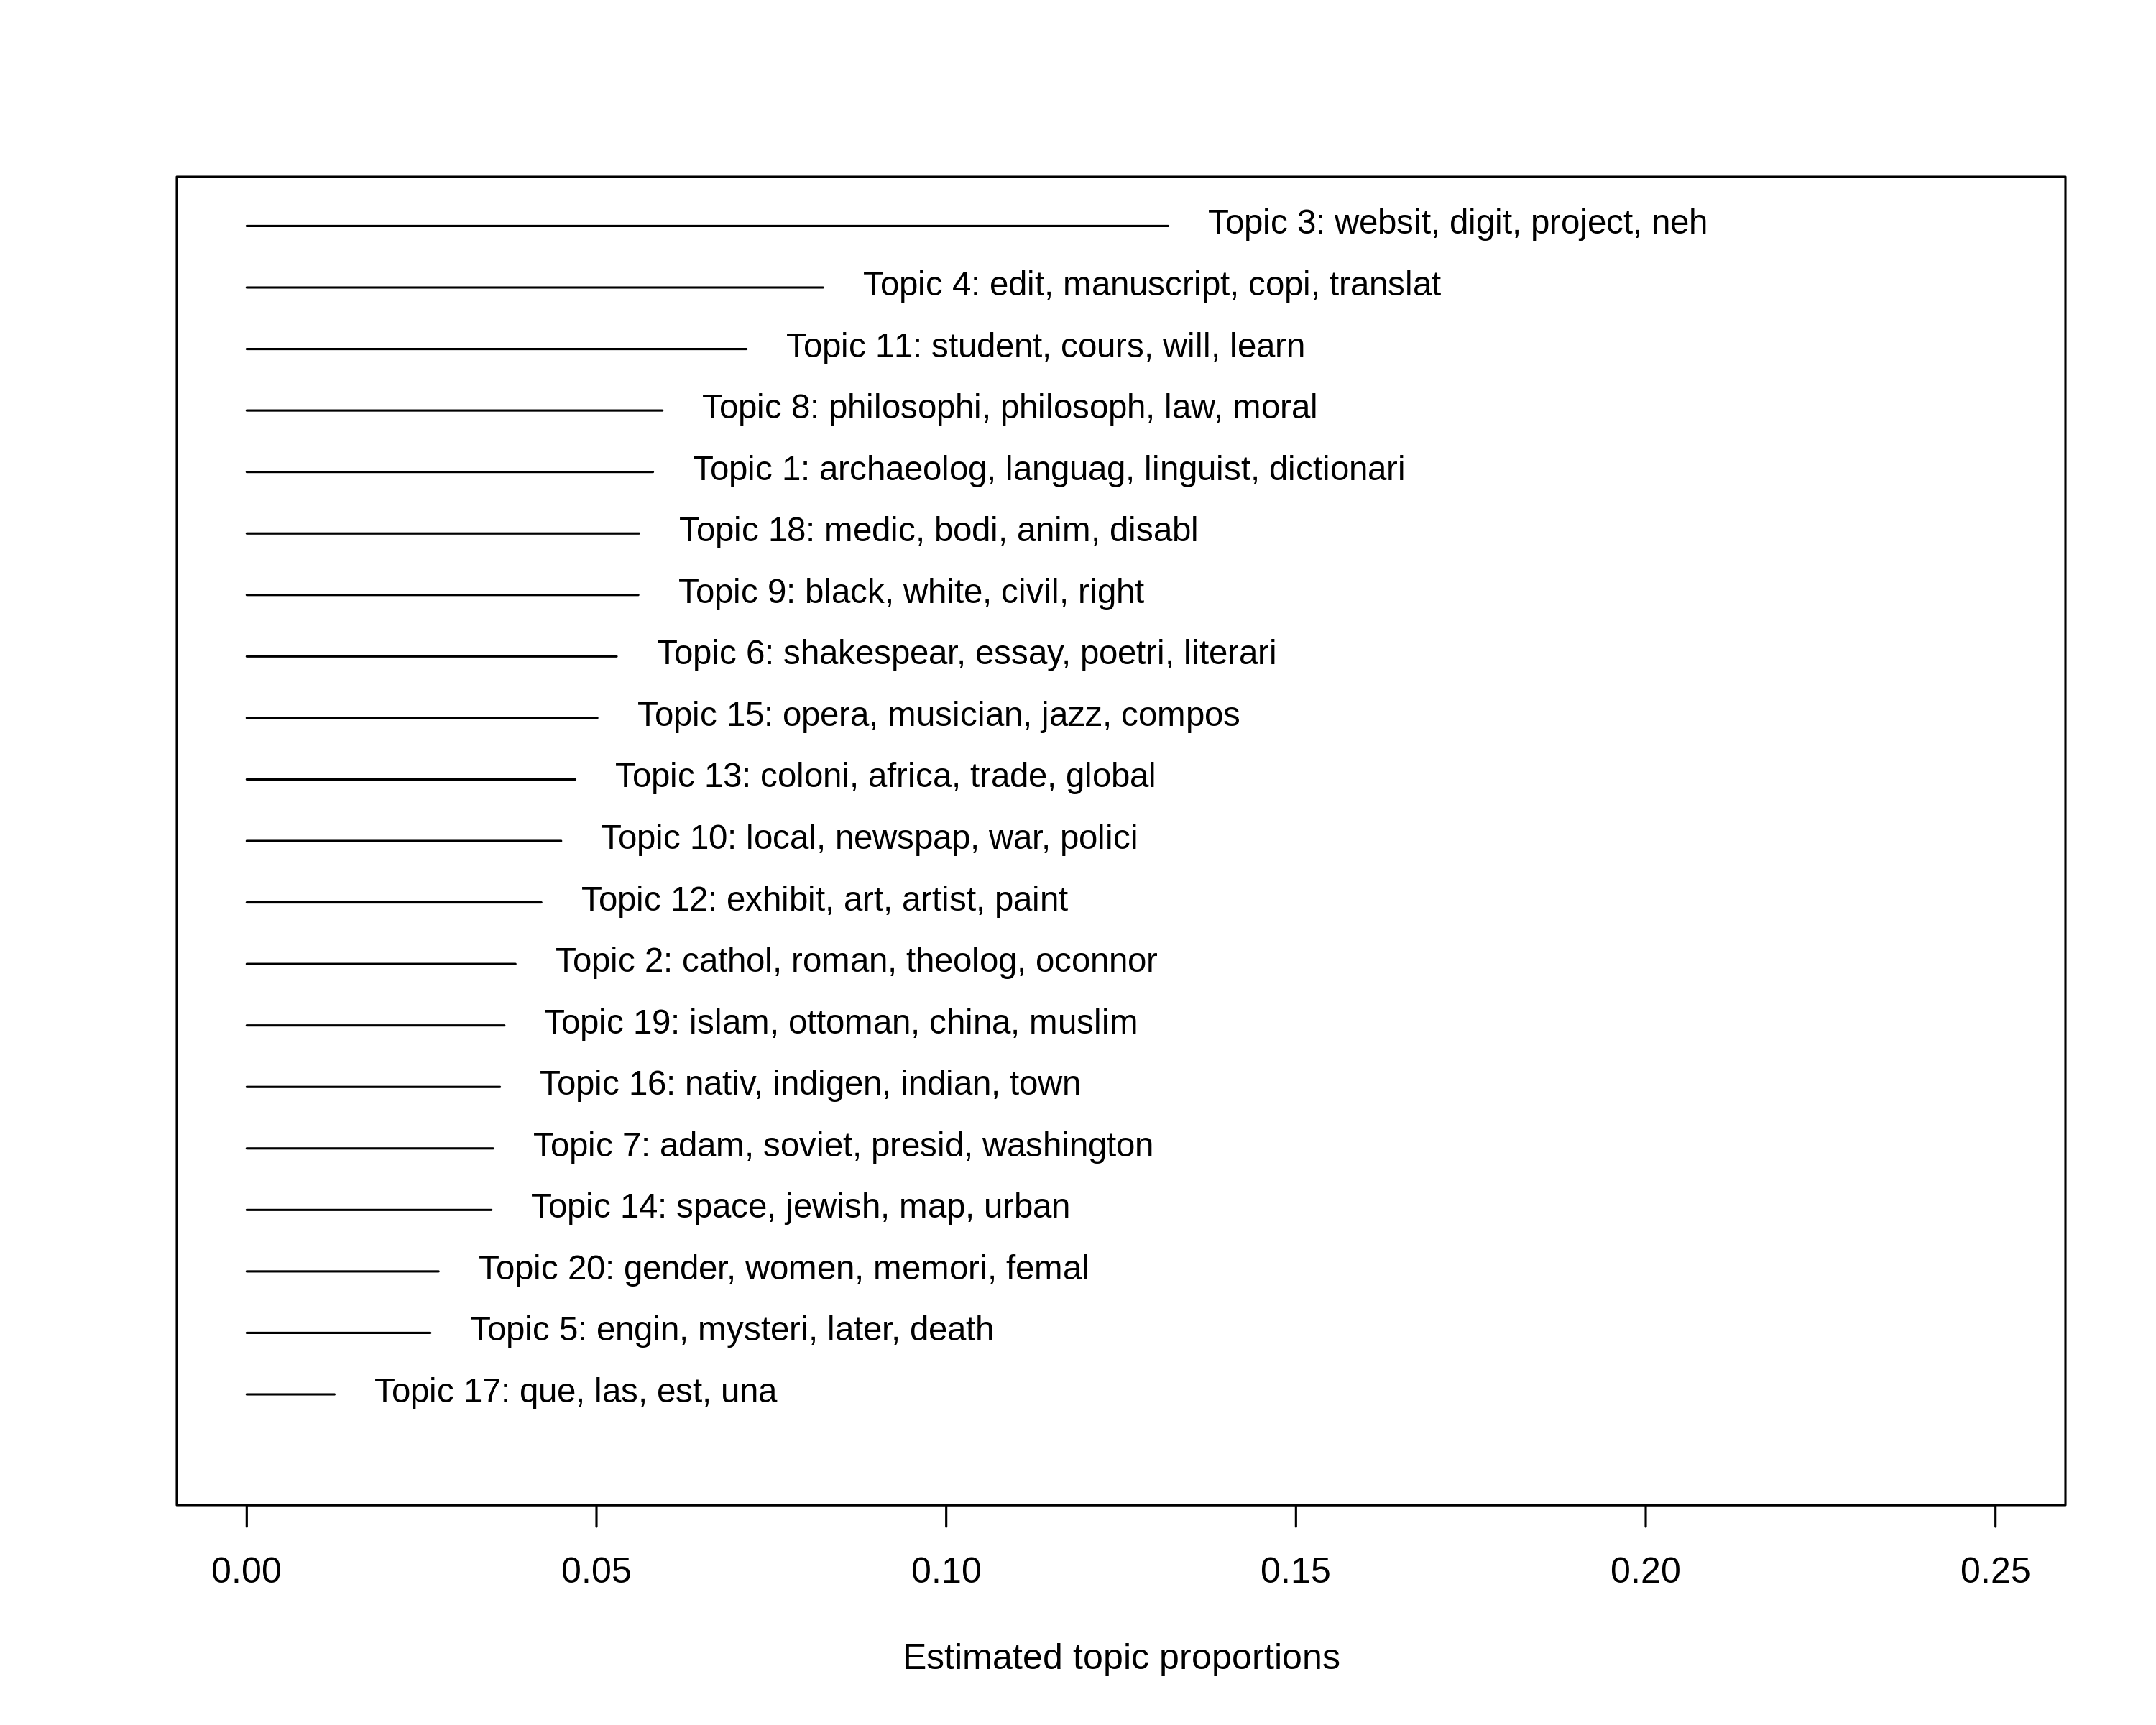

In [43]:
# Graphical display of estimated topic proportions
png(filename='../output/topic_frequencies.png', width = 2000, height = 1500, units = "px", res = 300)
plot(model, type = "summary", n = 4, xlim = c(0, 0.25), text.cex = 0.9485, 
     main = "", xlab = "Estimated topic proportions", labeltype = "frex", frexw = 0.7)
dev.off()

#options(repr.plot.width=10, repr.plot.height=8, repr.plot.res = 300)
plot(model, type = "summary", n = 4, xlim = c(0, 0.25), text.cex = 0.9485, 
     main = "", xlab = "Estimated topic proportions", labeltype = "frex", frexw = 0.7)

Inspecting valid thresholds via grid search. Progress:
  |======================================================================| 100%


png 
  2

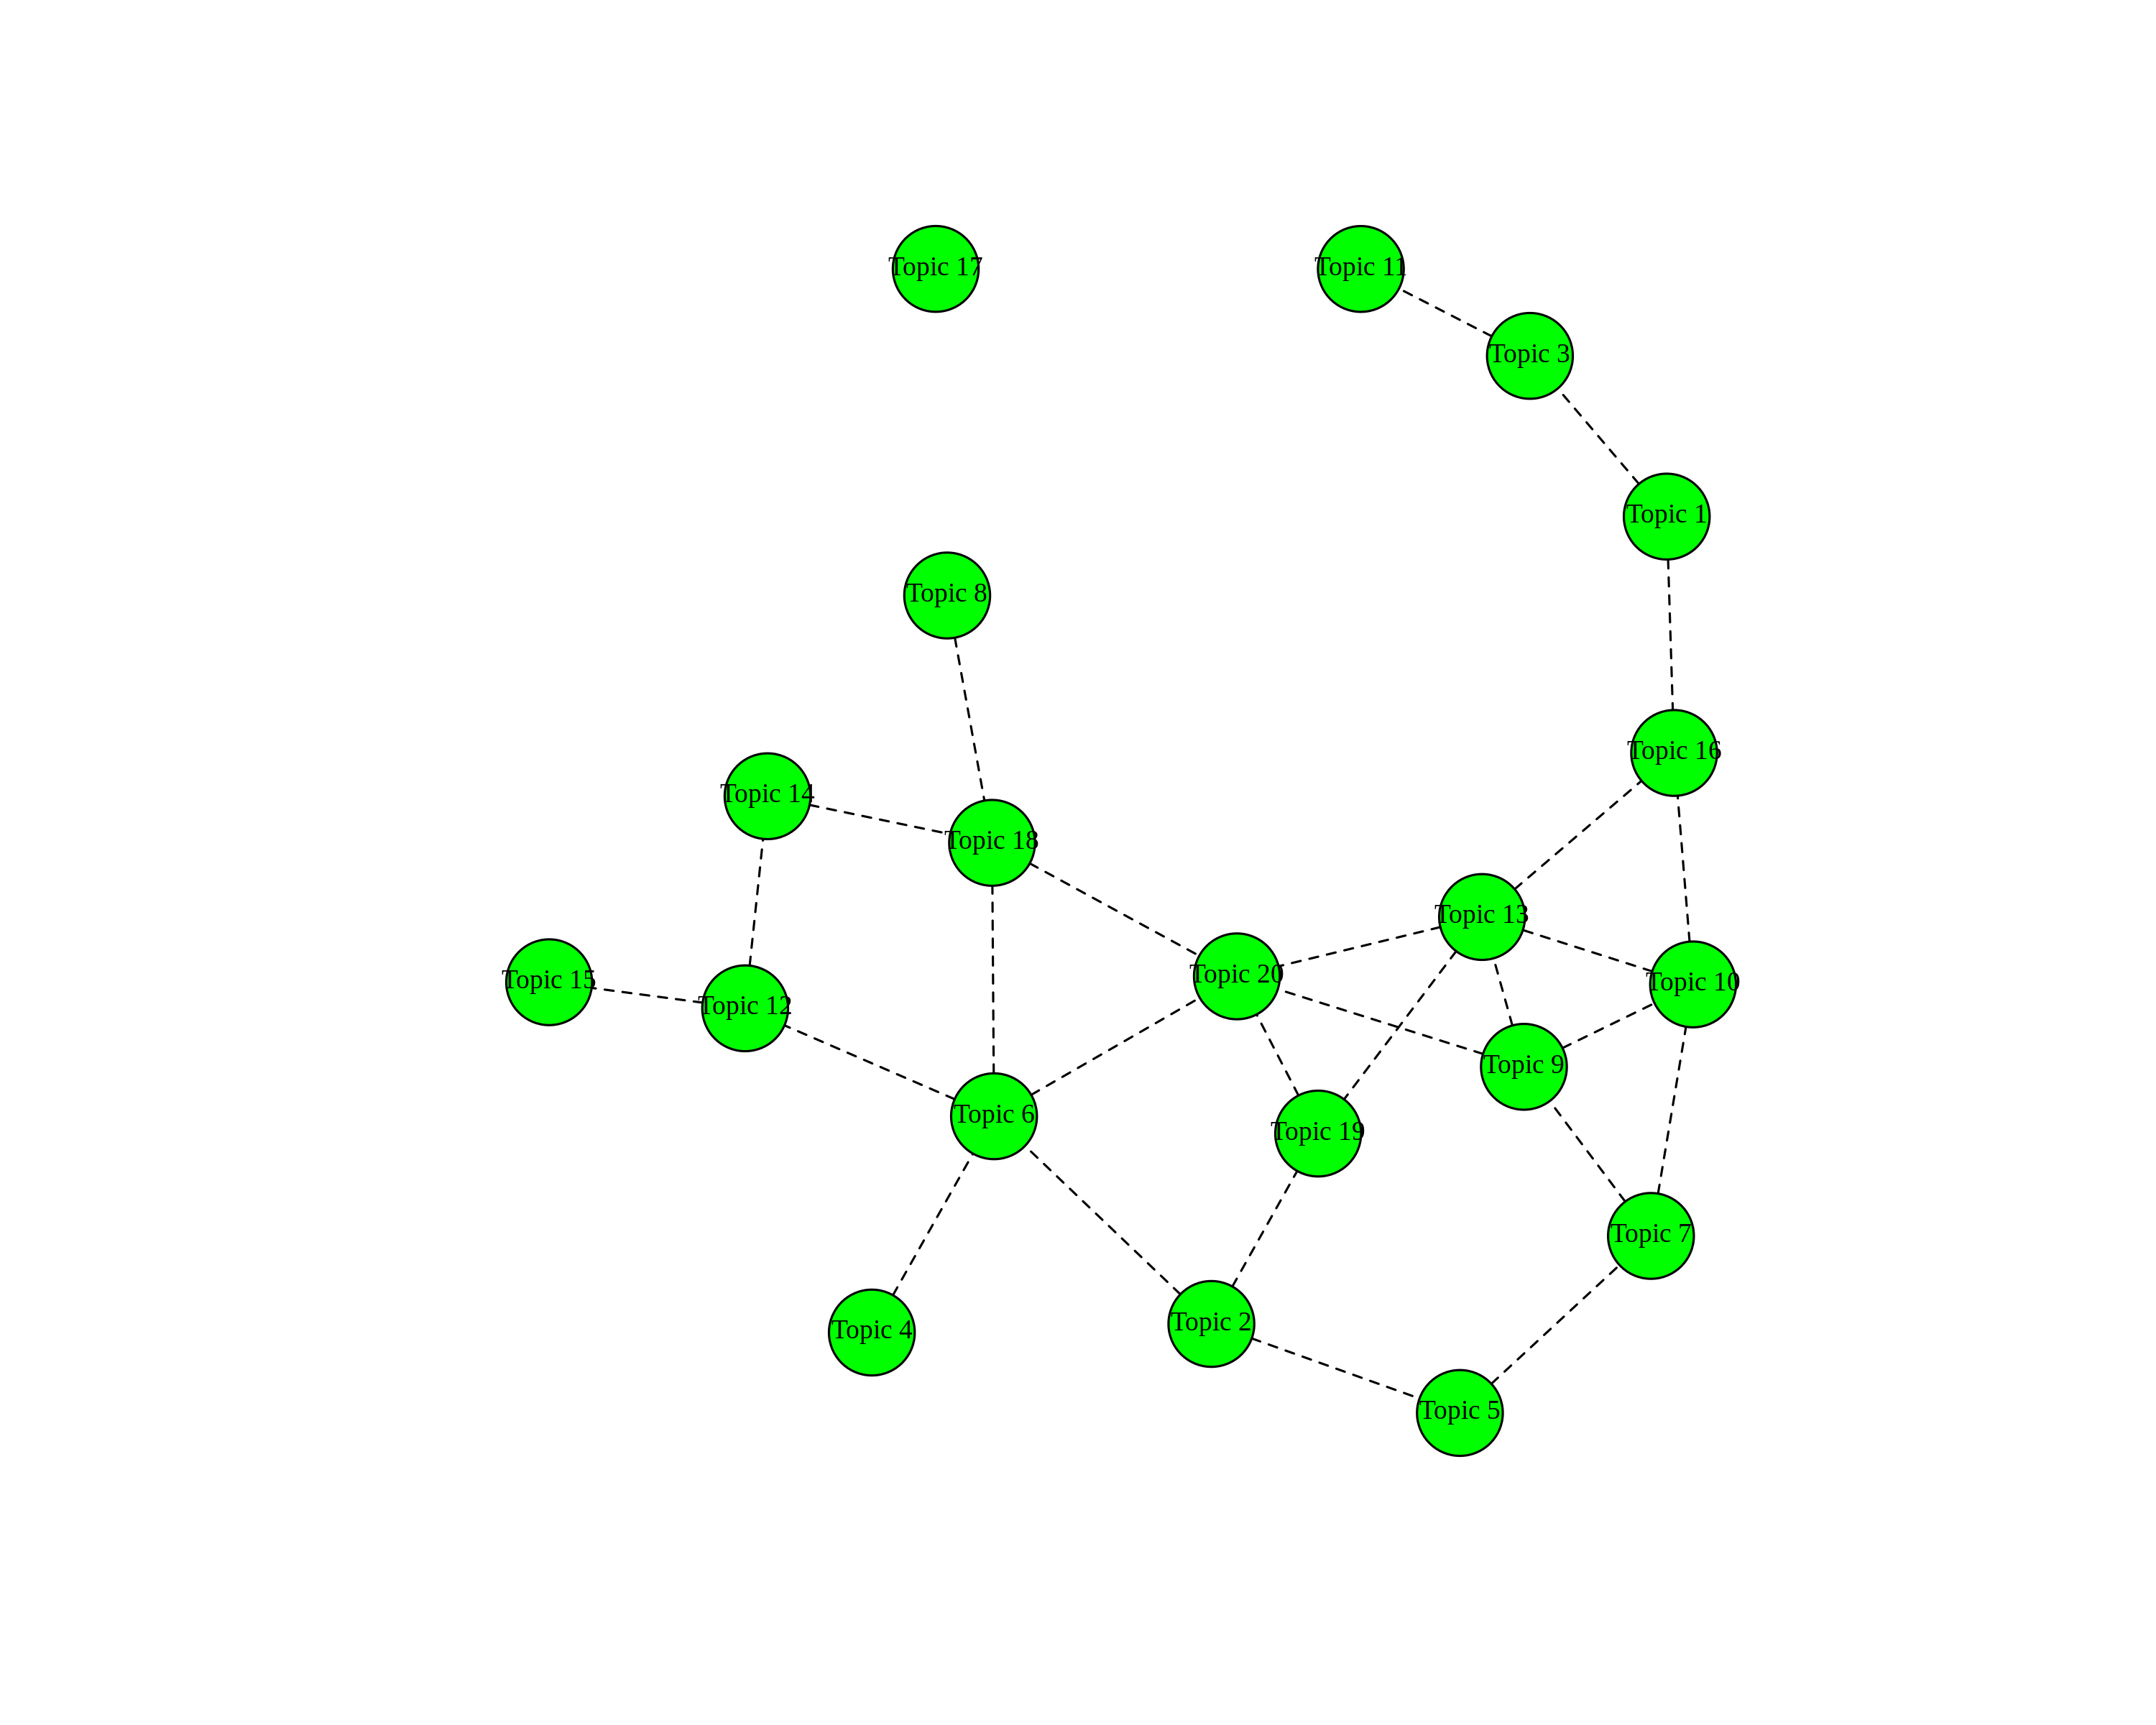

In [53]:
# Inspect topic correlations

# This makes a persistent file:
stmCorrViz(model, 
           file_out = '../output/corrviz.html',
           documents_matrix = docs, 
           title = "Topic Correlations (k = 20)", 
           display = FALSE)

# This saves an image to disk:
png(filename='../output/corrviz.png', width = 2000, height = 2000, units = "px", res = 300)
corr = topicCorr(model)
plot(corr)
dev.off()

# This displays the plot:
plot(corr)

## Estimate topic relationships with gender

In [47]:
# Estimate relationships with linear model
gender_effect <- estimateEffect(~ Year + Male,
                               model, meta = meta, uncertainty = "Global")
summary(gender_effect)


Call:
estimateEffect(formula = ~Year + Male, stmobj = model, metadata = meta, 
    uncertainty = "Global")


Topic 1:

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.9040811  0.7056413  -4.116 3.91e-05 ***
Year         0.0014675  0.0003501   4.192 2.80e-05 ***
Male         0.0107911  0.0039229   2.751  0.00596 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Topic 2:

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.1322517  0.7039245   5.870 4.55e-09 ***
Year        -0.0020281  0.0003489  -5.814 6.38e-09 ***
Male        -0.0051898  0.0033435  -1.552    0.121    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Topic 3:

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -8.7094819  1.0598302  -8.218 2.44e-16 ***
Year         0.0043769  0.0005258   8.323  < 2e-16 ***
Male        -0.0032971  0.0050845  -0.648    0.517    
---
Signif. codes:  

In [48]:
# Save regression results to CSV
tidy_frame <- tidy(gender_effect) # Tidy up output

# Function for converting p.value into asterisks:
signif.num <- function(x) {
    symnum(x, corr = FALSE, na = FALSE, legend = FALSE,
           cutpoints = c(0, 0.001, 0.01, 0.05, 0.1, 1), 
           symbols = c("***", "**", "*", ".", " "))
}

toDel <- seq(1, nrow(tidy_frame), 3); tidy_frame <- tidy_frame[ -toDel,] # keep only Year and Male coefficients: Capture every 1st row from start in batches of 3
tidy_frame$estimate <- format(tidy_frame$estimate, digits=3) # Reduce to 3 significant figures

tidy_frame$signif <- signif.num(tidy_frame$p.value) # Derive asterisks from p.value
keepcols = c("topic", "term", "estimate", "signif") # Define columns to keep

tidy_frame <- tidy_frame[keepcols] # Drop unnecessary columns
write.csv(tidy_frame,'../output/estimate_topic_effects.csv') # Save new DF to CSV
tidy_frame # Look at clean results

topic,term,estimate,signif
<int>,<chr>,<chr>,<noquote>
1,Year,1.46e-03,***
1,Male,1.08e-02,**
2,Year,-2.03e-03,***
2,Male,-5.19e-03,
3,Year,4.38e-03,***
3,Male,-3.23e-03,
4,Year,-2.75e-03,***
4,Male,2.73e-02,***
5,Year,-3.16e-05,


## Visualize topic/gender relationships

png 
  2

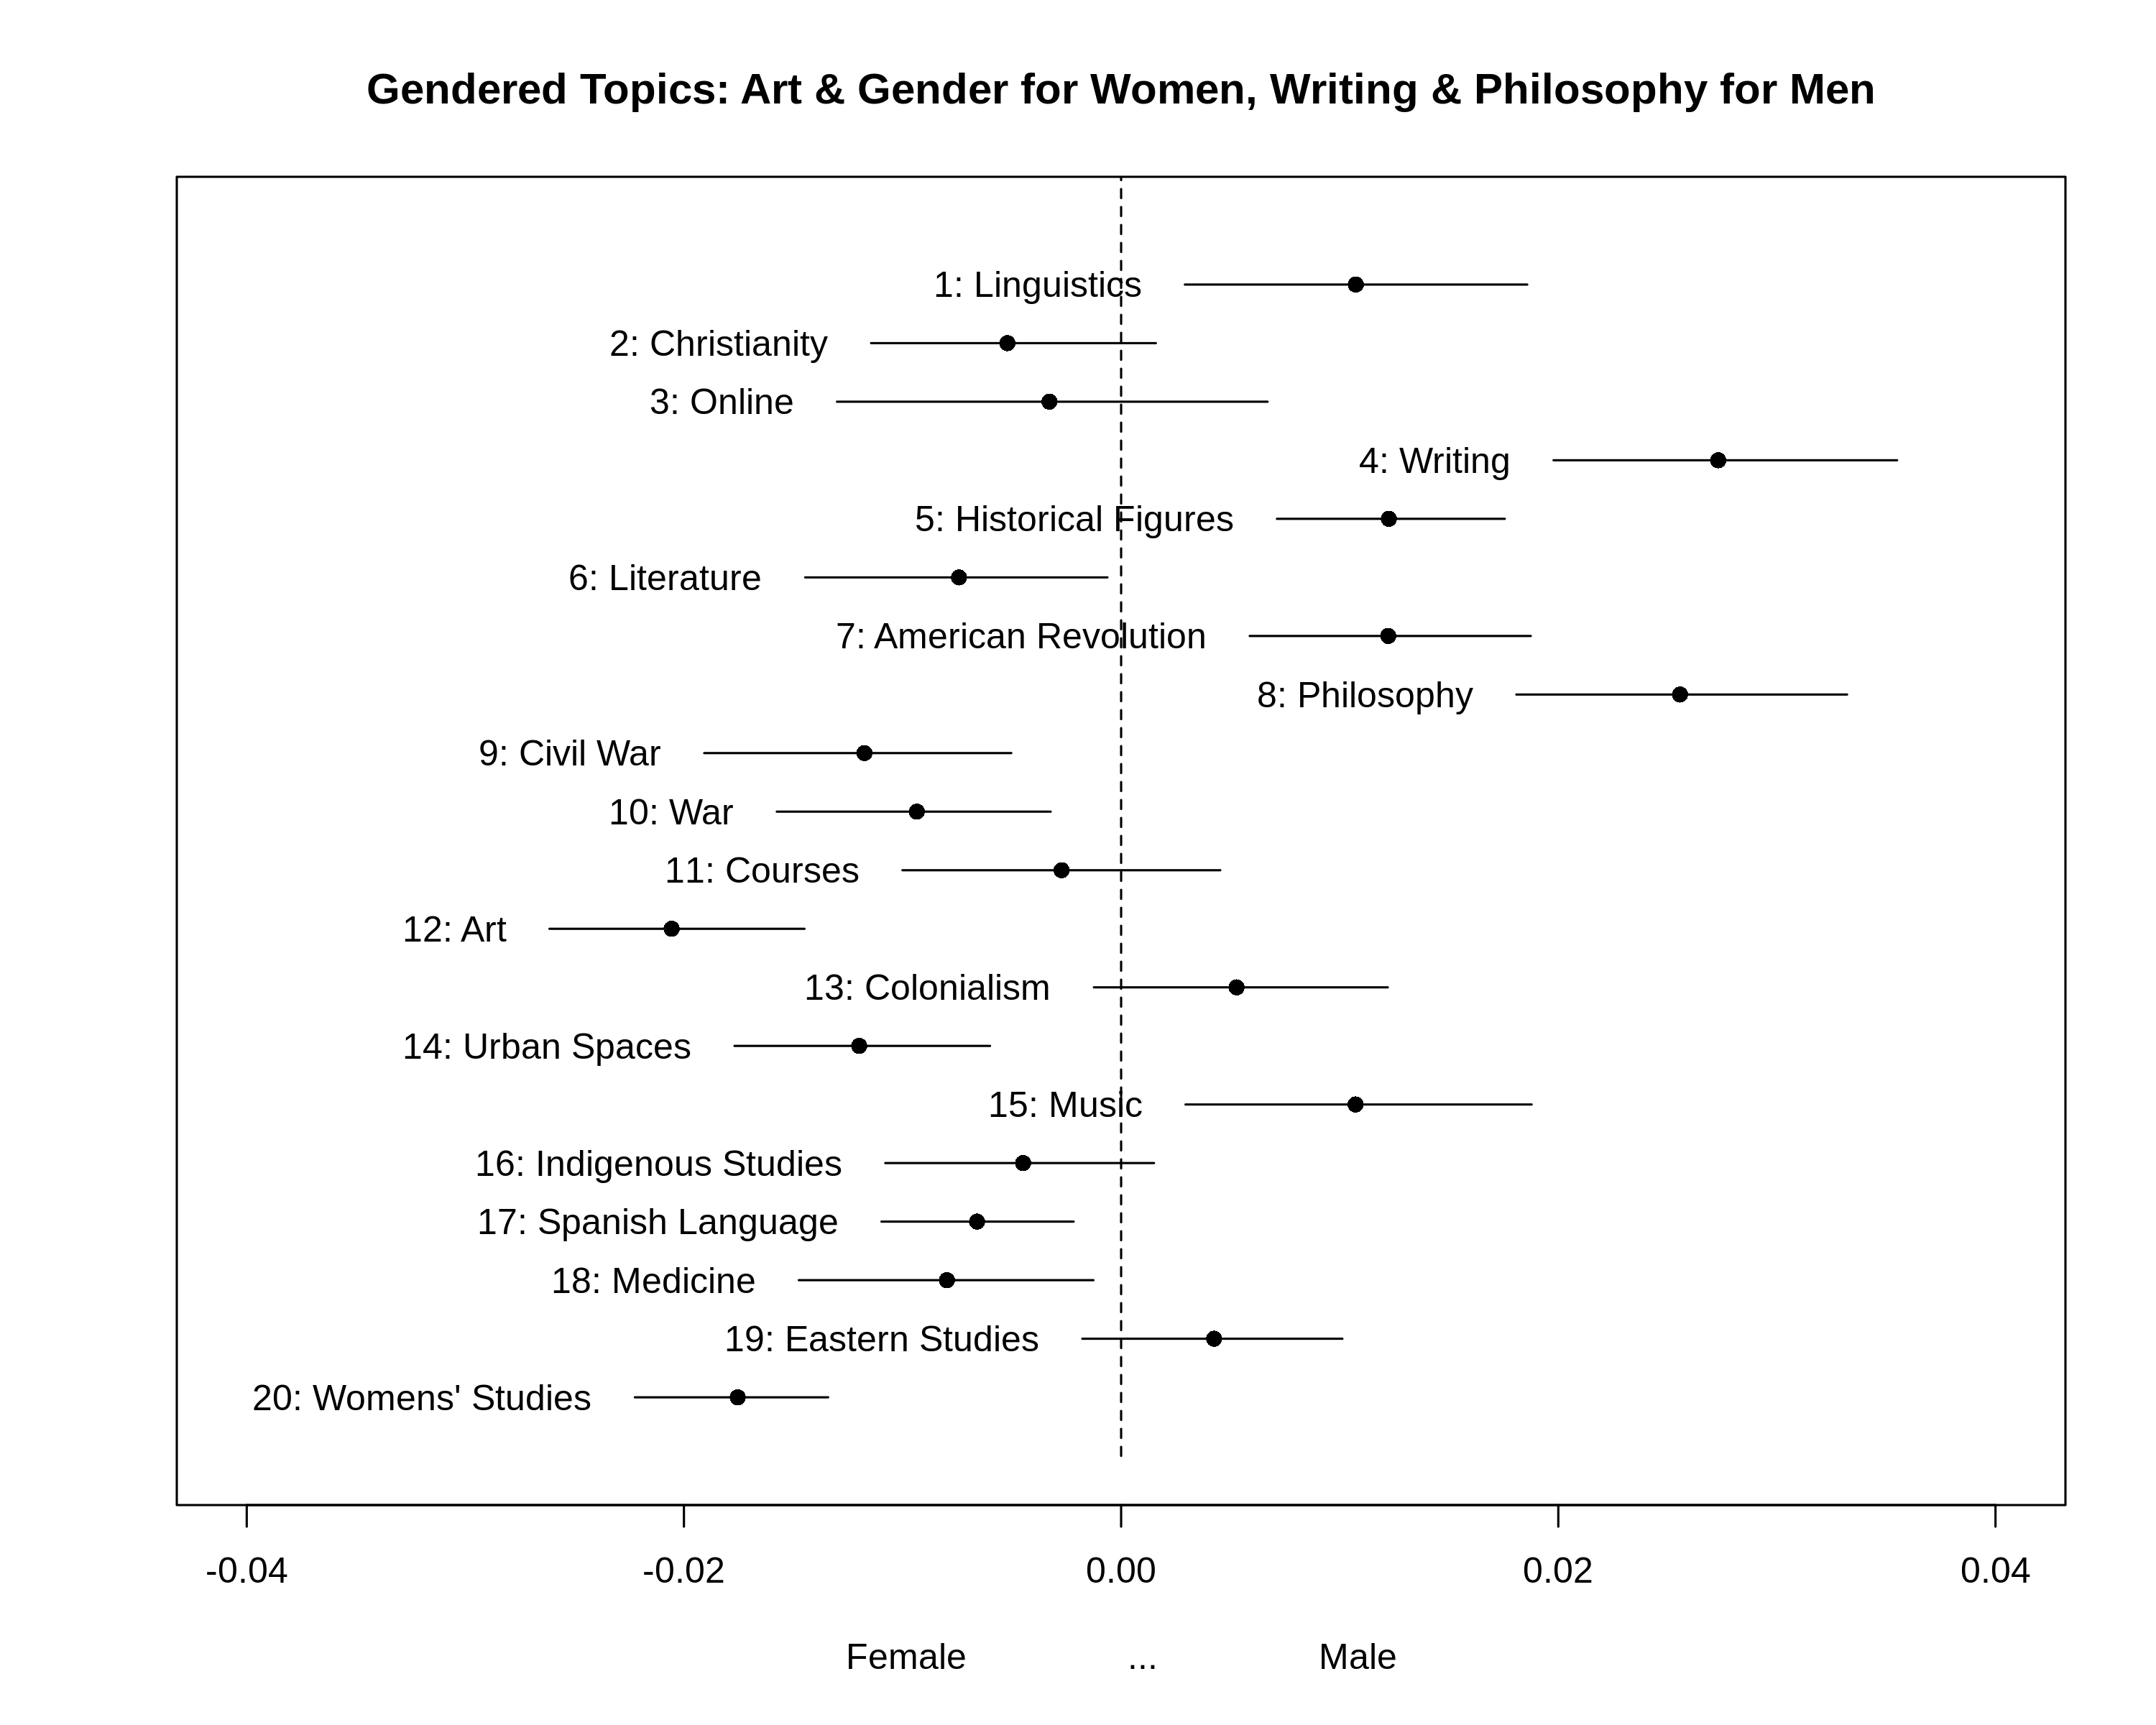

In [61]:
## Which topics are associated with male authors and which with female authors?
# Graph relationship between gender and selected topics
x_label = "Female                ...                Male"
title = "Gendered Topics: Art & Gender for Women, Writing & Philosophy for Men"

# Show figure
plot(gender_effect, covariate="Male", topics=c(1:20), model=model,
     method="difference", cov.value1=1, cov.value2=0,
     xlab=x_label, main=title,
     xlim=c(-.04, .04), width=80, labeltype="custom",
     custom.labels=c("1: Linguistics", "2: Christianity", "3: Online", "4: Writing", 
                     "5: Historical Figures", "6: Literature", "7: American Revolution", "8: Philosophy", 
                     "9: Civil War", "10: War", "11: Courses", "12: Art", 
                     "13: Colonialism", "14: Urban Spaces", "15: Music", "16: Indigenous Studies", 
                     "17: Spanish Language", "18: Medicine", "19: Eastern Studies", "20: Womens' Studies"))

# Save figure to disk
png(filename='../output/gender_and_topics.png', width = 2500, height = 2000, units = "px", res = 300)
plot(gender_effect, covariate="Male", topics=c(1:20), model=model,
     method="difference", cov.value1=1, cov.value2=0,
     xlab=x_label, main=title,
     xlim=c(-.04, .04), width=80, labeltype="custom",
     custom.labels=c("1: Linguistics", "2: Christianity", "3: Online", "4: Writing", 
                     "5: Historical Figures", "6: Literature", "7: American Revolution", "8: Philosophy", 
                     "9: Civil War", "10: War", "11: Courses", "12: Art", 
                     "13: Colonialism", "14: Urban Spaces", "15: Music", "16: Indigenous Studies", 
                     "17: Spanish Language", "18: Medicine", "19: Eastern Studies", "20: Womens' Studies"))
dev.off()

png 
  2

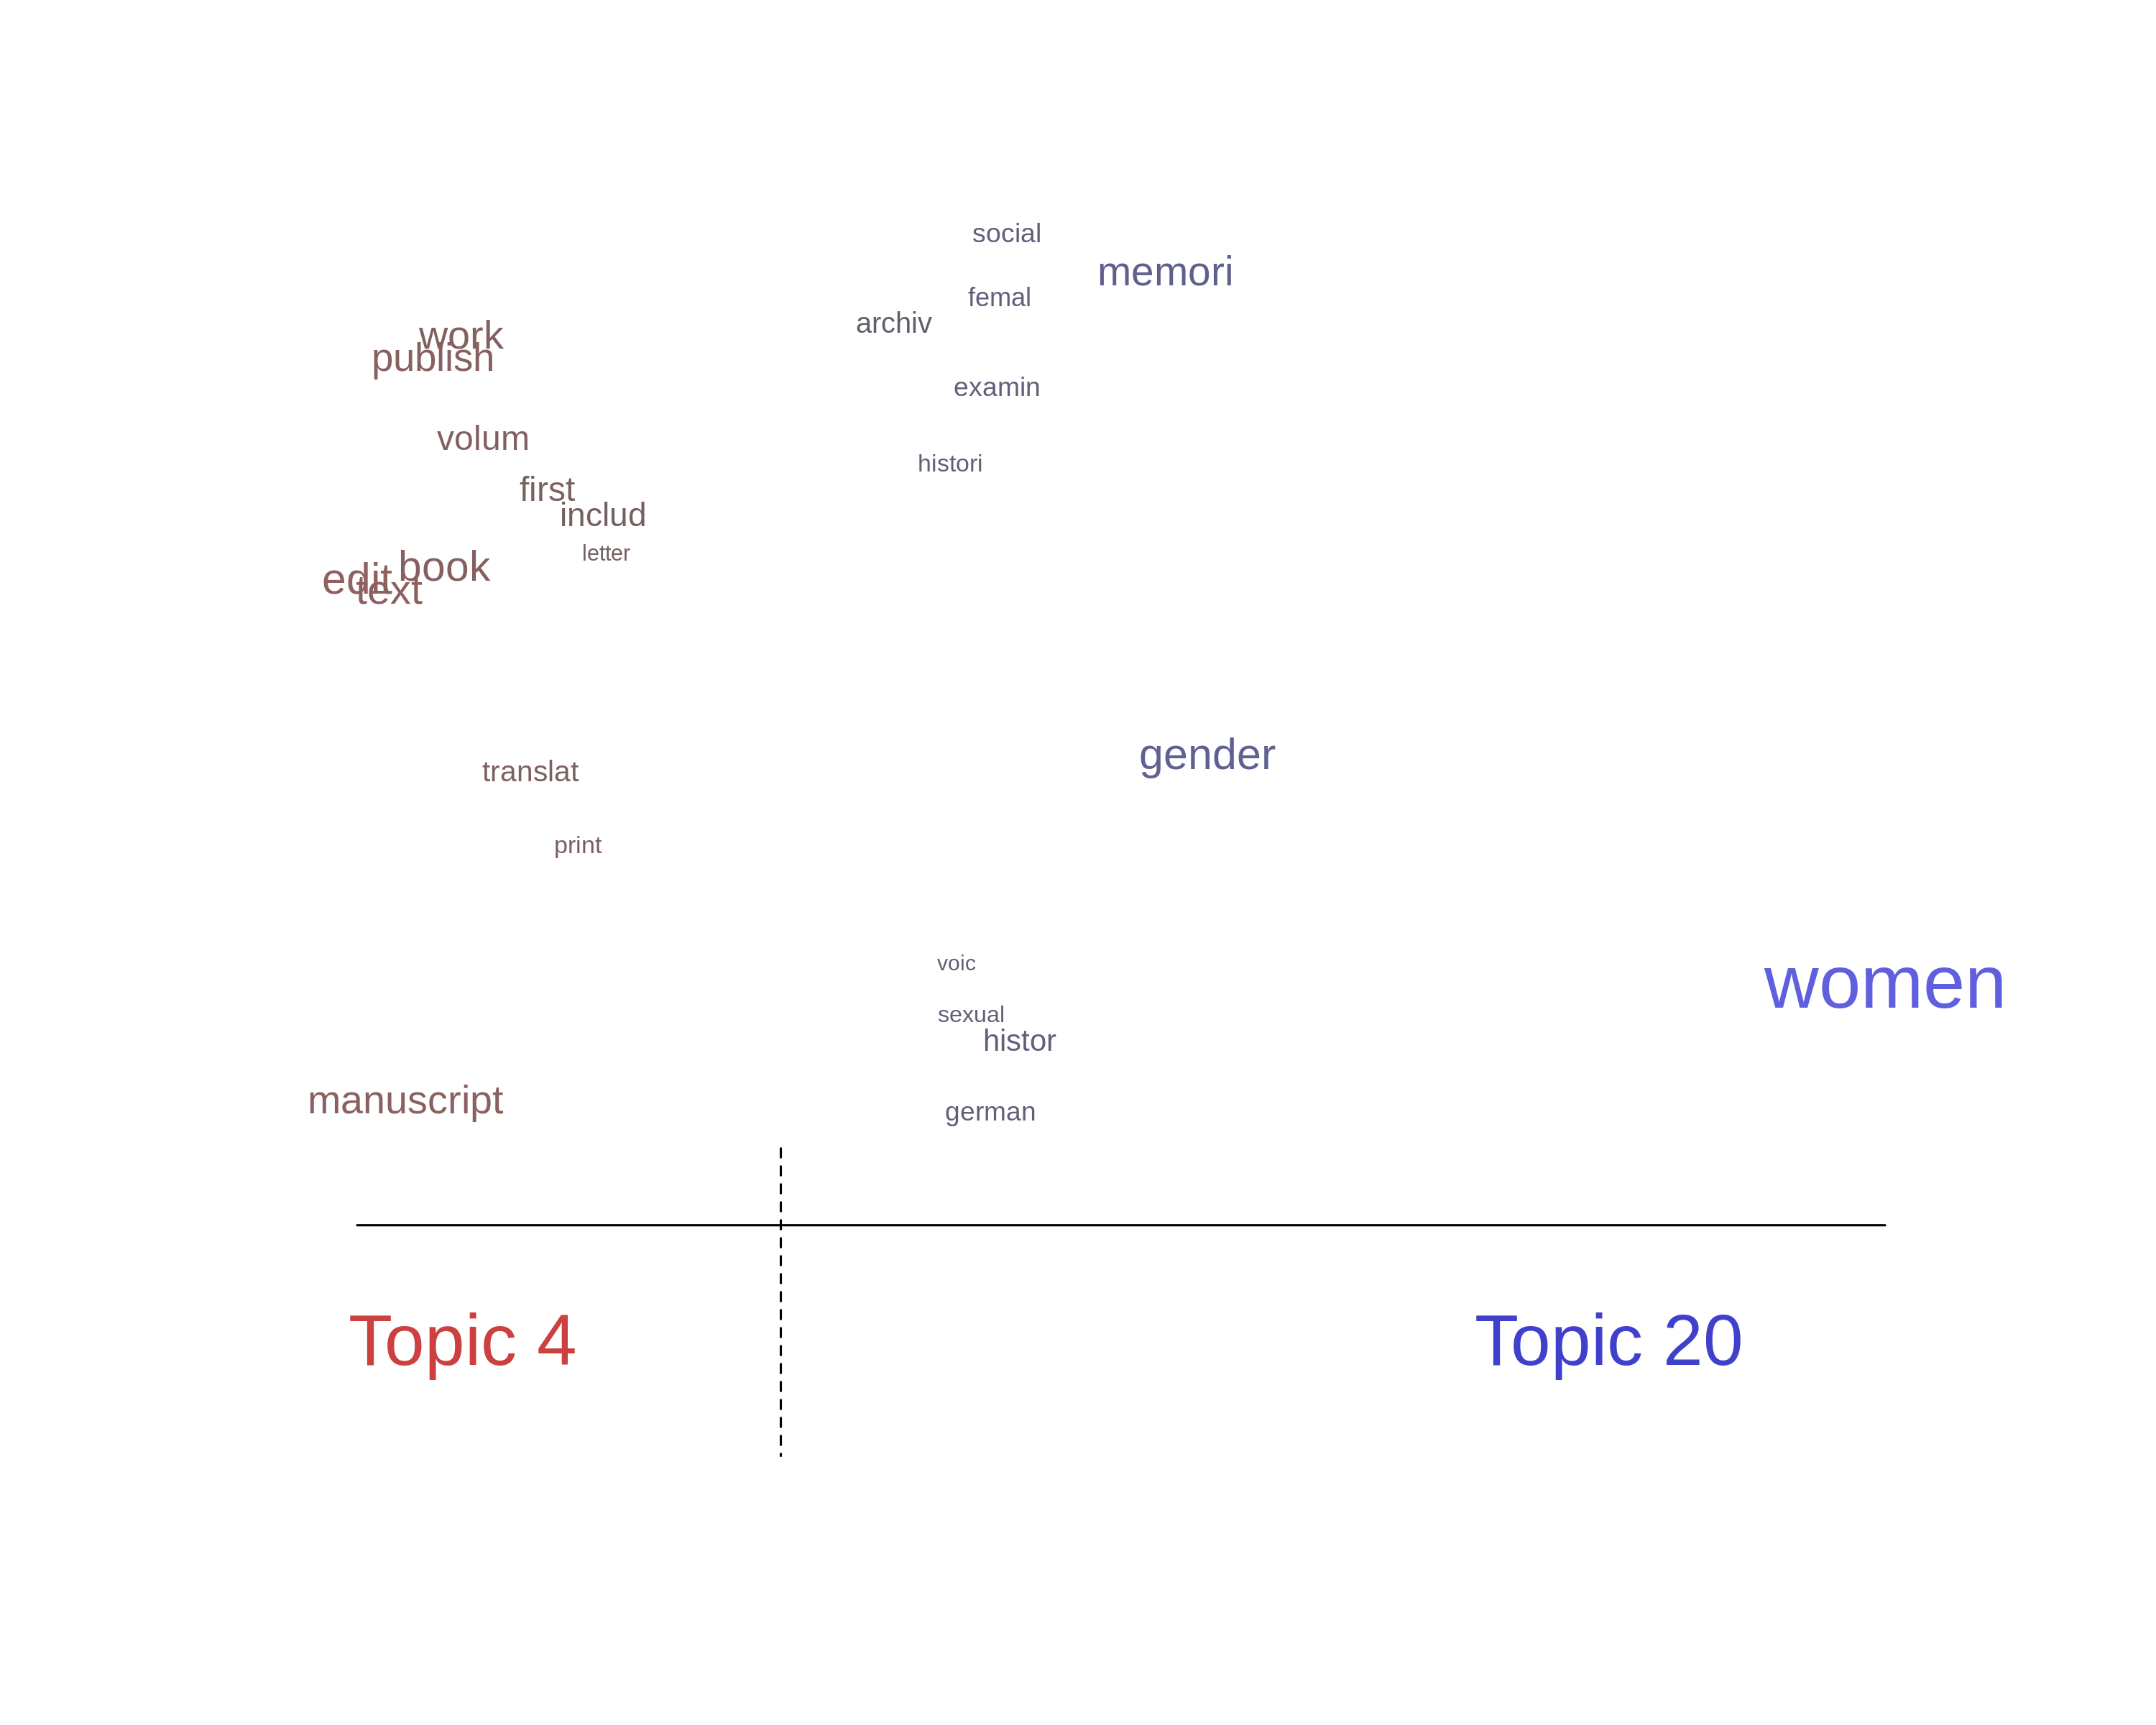

In [52]:
# Visualize topical contrast: Writing vs. womens' studies (male vs. female topics)

# Show figure
plot(model, type = "perspectives", width=100, topics = c(4,20))

# Save figure to disk
png(filename='../output/topic_contrast_writing_womens-studies.png', width = 2000, height = 2000, units = "px", res = 300)
plot(model, type = "perspectives", width=100, topics = c(4,20))
dev.off()

png 
  2

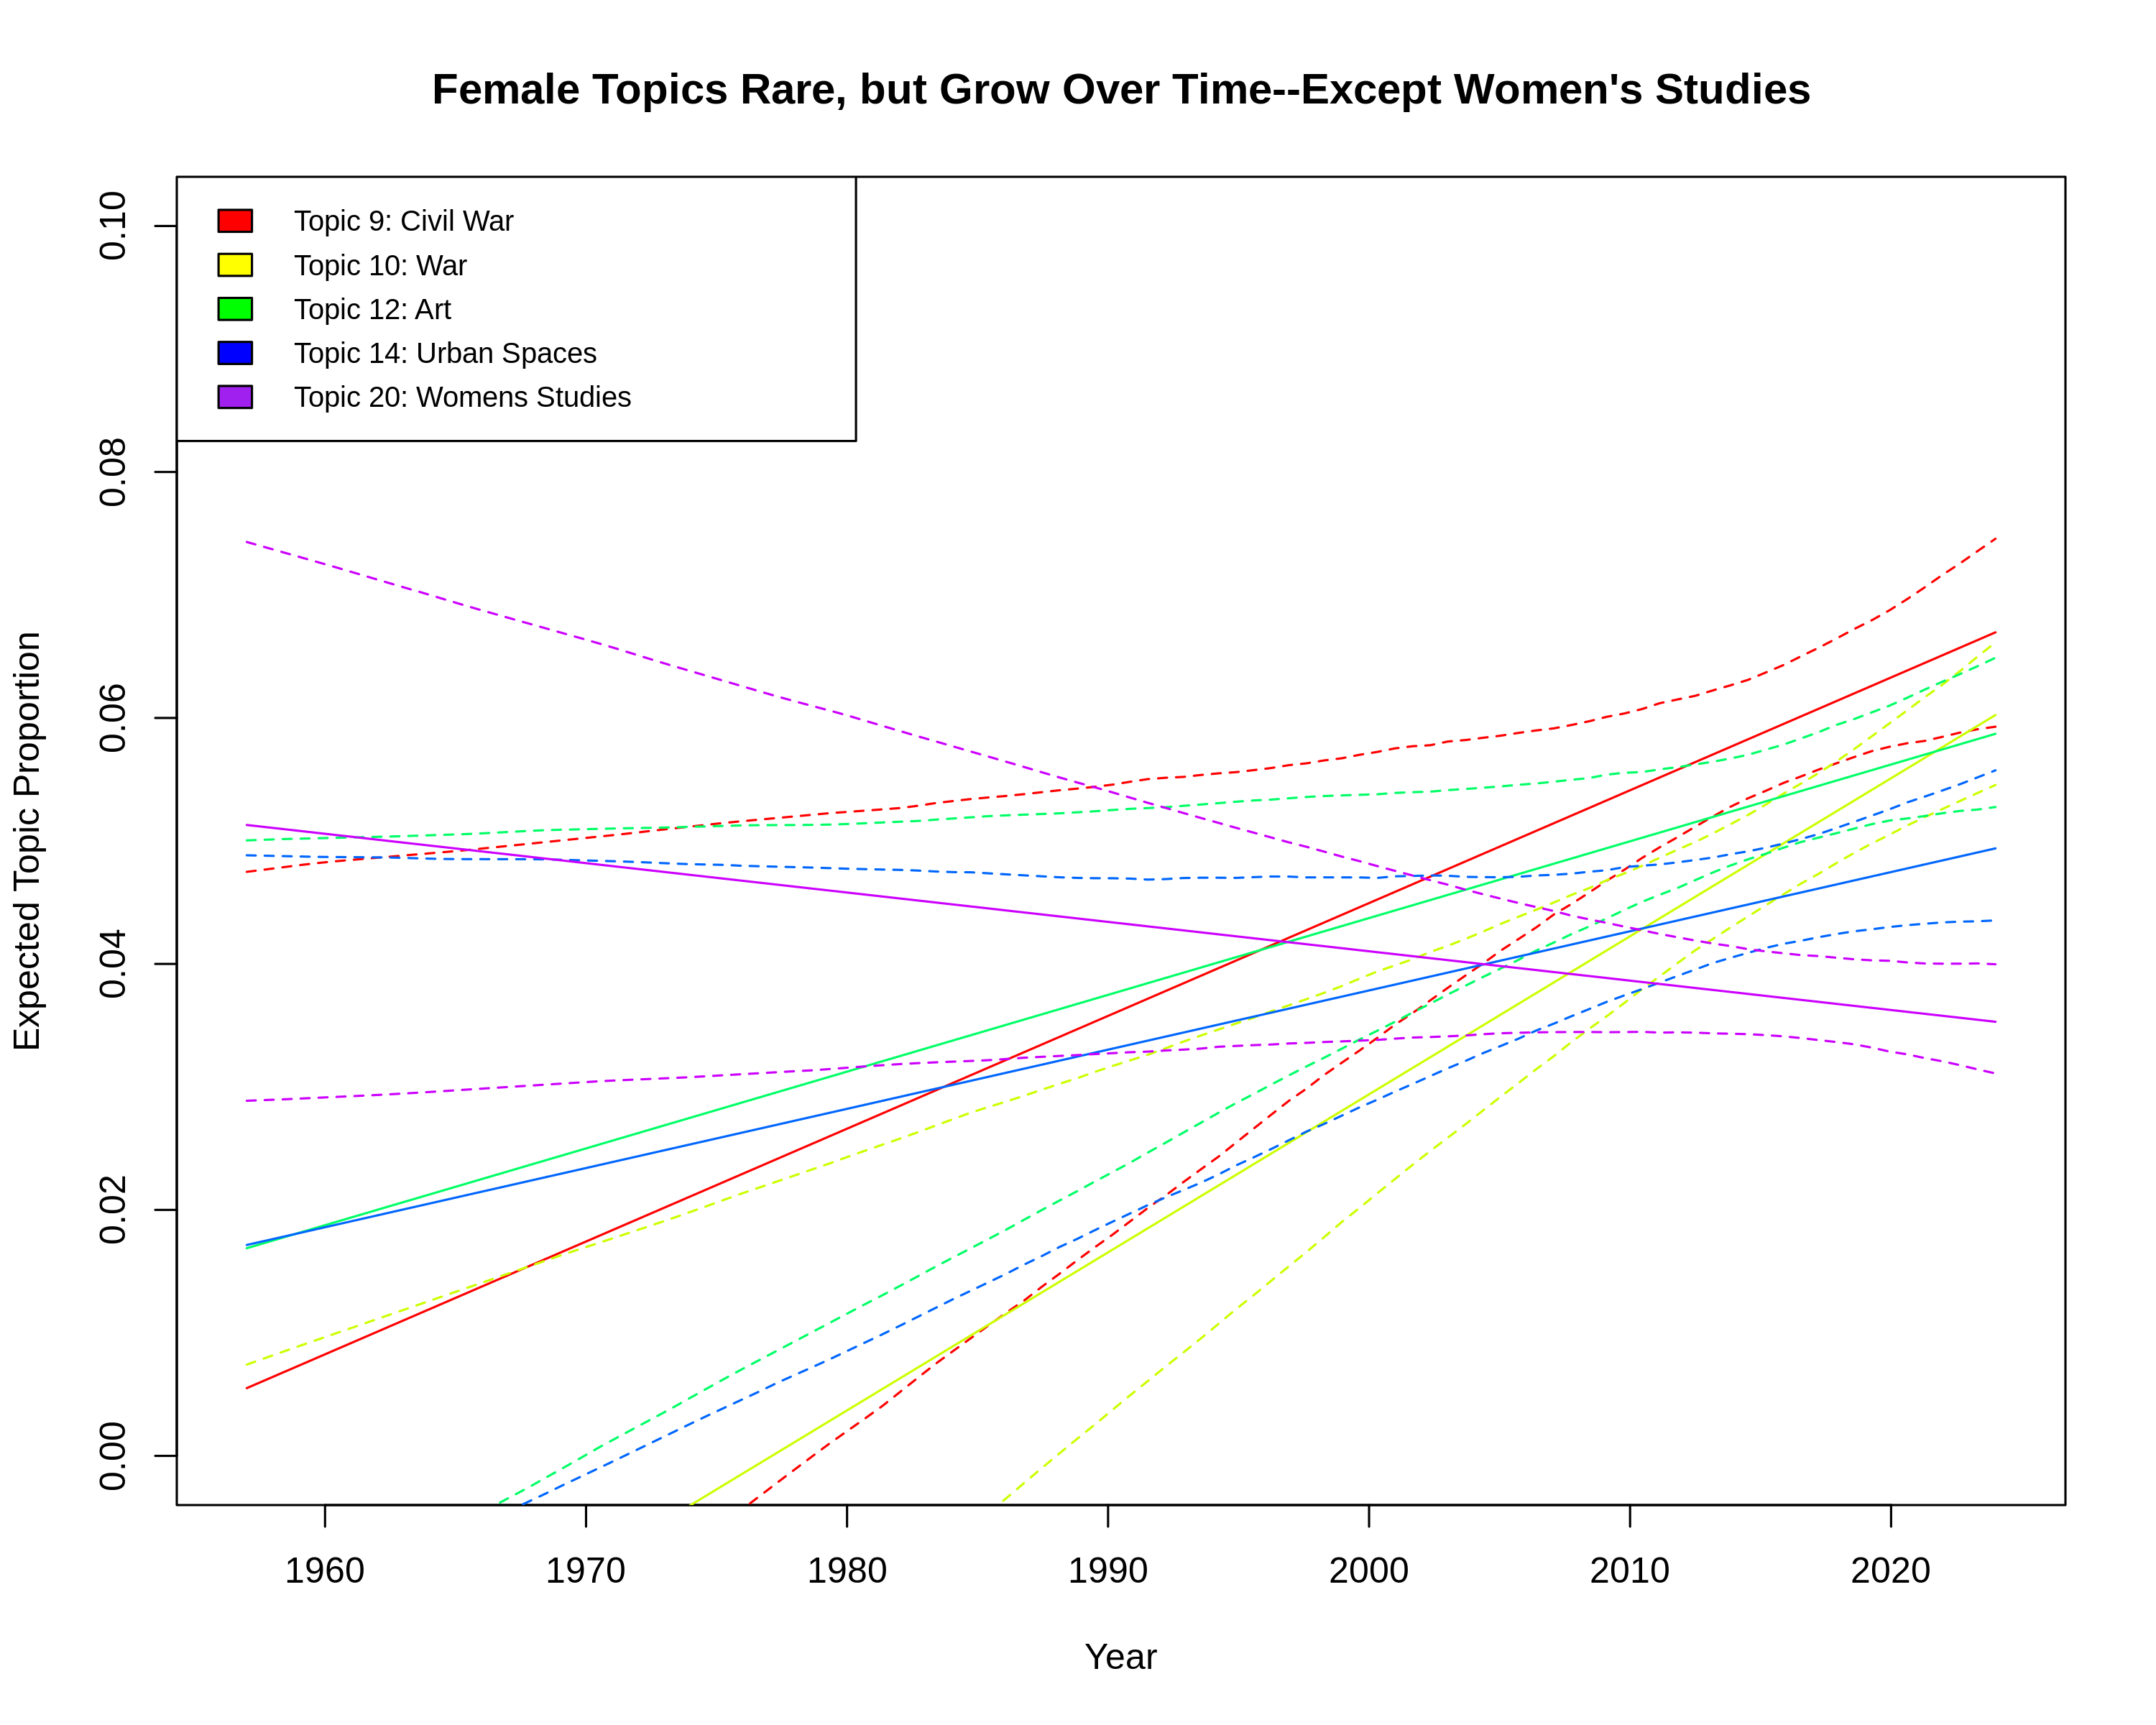

In [62]:
# Visualize topical prevalence over time for female-specific topics
title = "Female Topics Rare, but Grow Over Time--Except Women's Studies"
legend = c("Topic 9: Civil War", "Topic 10: War", "Topic 12: Art", 
           "Topic 14: Urban Spaces", "Topic 20: Womens Studies")
#options(repr.plot.width = 20, repr.plot.height = 15, repr.plot.res = 100) # set plot size

# Show figure
plot(gender_effect, covariate="Year", topics=c(9, 10, 12, 14, 20), method="continuous", 
     model=model, xlab="Year", printlegend=FALSE, main=title, ylim = c(0, .1), 
    theme(text = element_text(size = 2), element_line(linewidth = 0.1)))
legend(x="topleft", legend=legend, fill=c("red", "yellow", "green", "blue", "purple"), cex=0.8)

# Save figure to disk
png(filename='../output/female_topics_over_time.png', width = 2000, height = 2000, units = "px", res = 300)
plot(gender_effect, covariate="Year", topics=c(9, 10, 12, 14, 20), method="continuous", 
     model=model, xlab="Year", printlegend=FALSE, main=title, ylim = c(0, .1))
legend(x="topleft", legend=legend, fill=c("red", "yellow", "green", "blue", "purple"), cex=0.8)
dev.off()

png 
  2

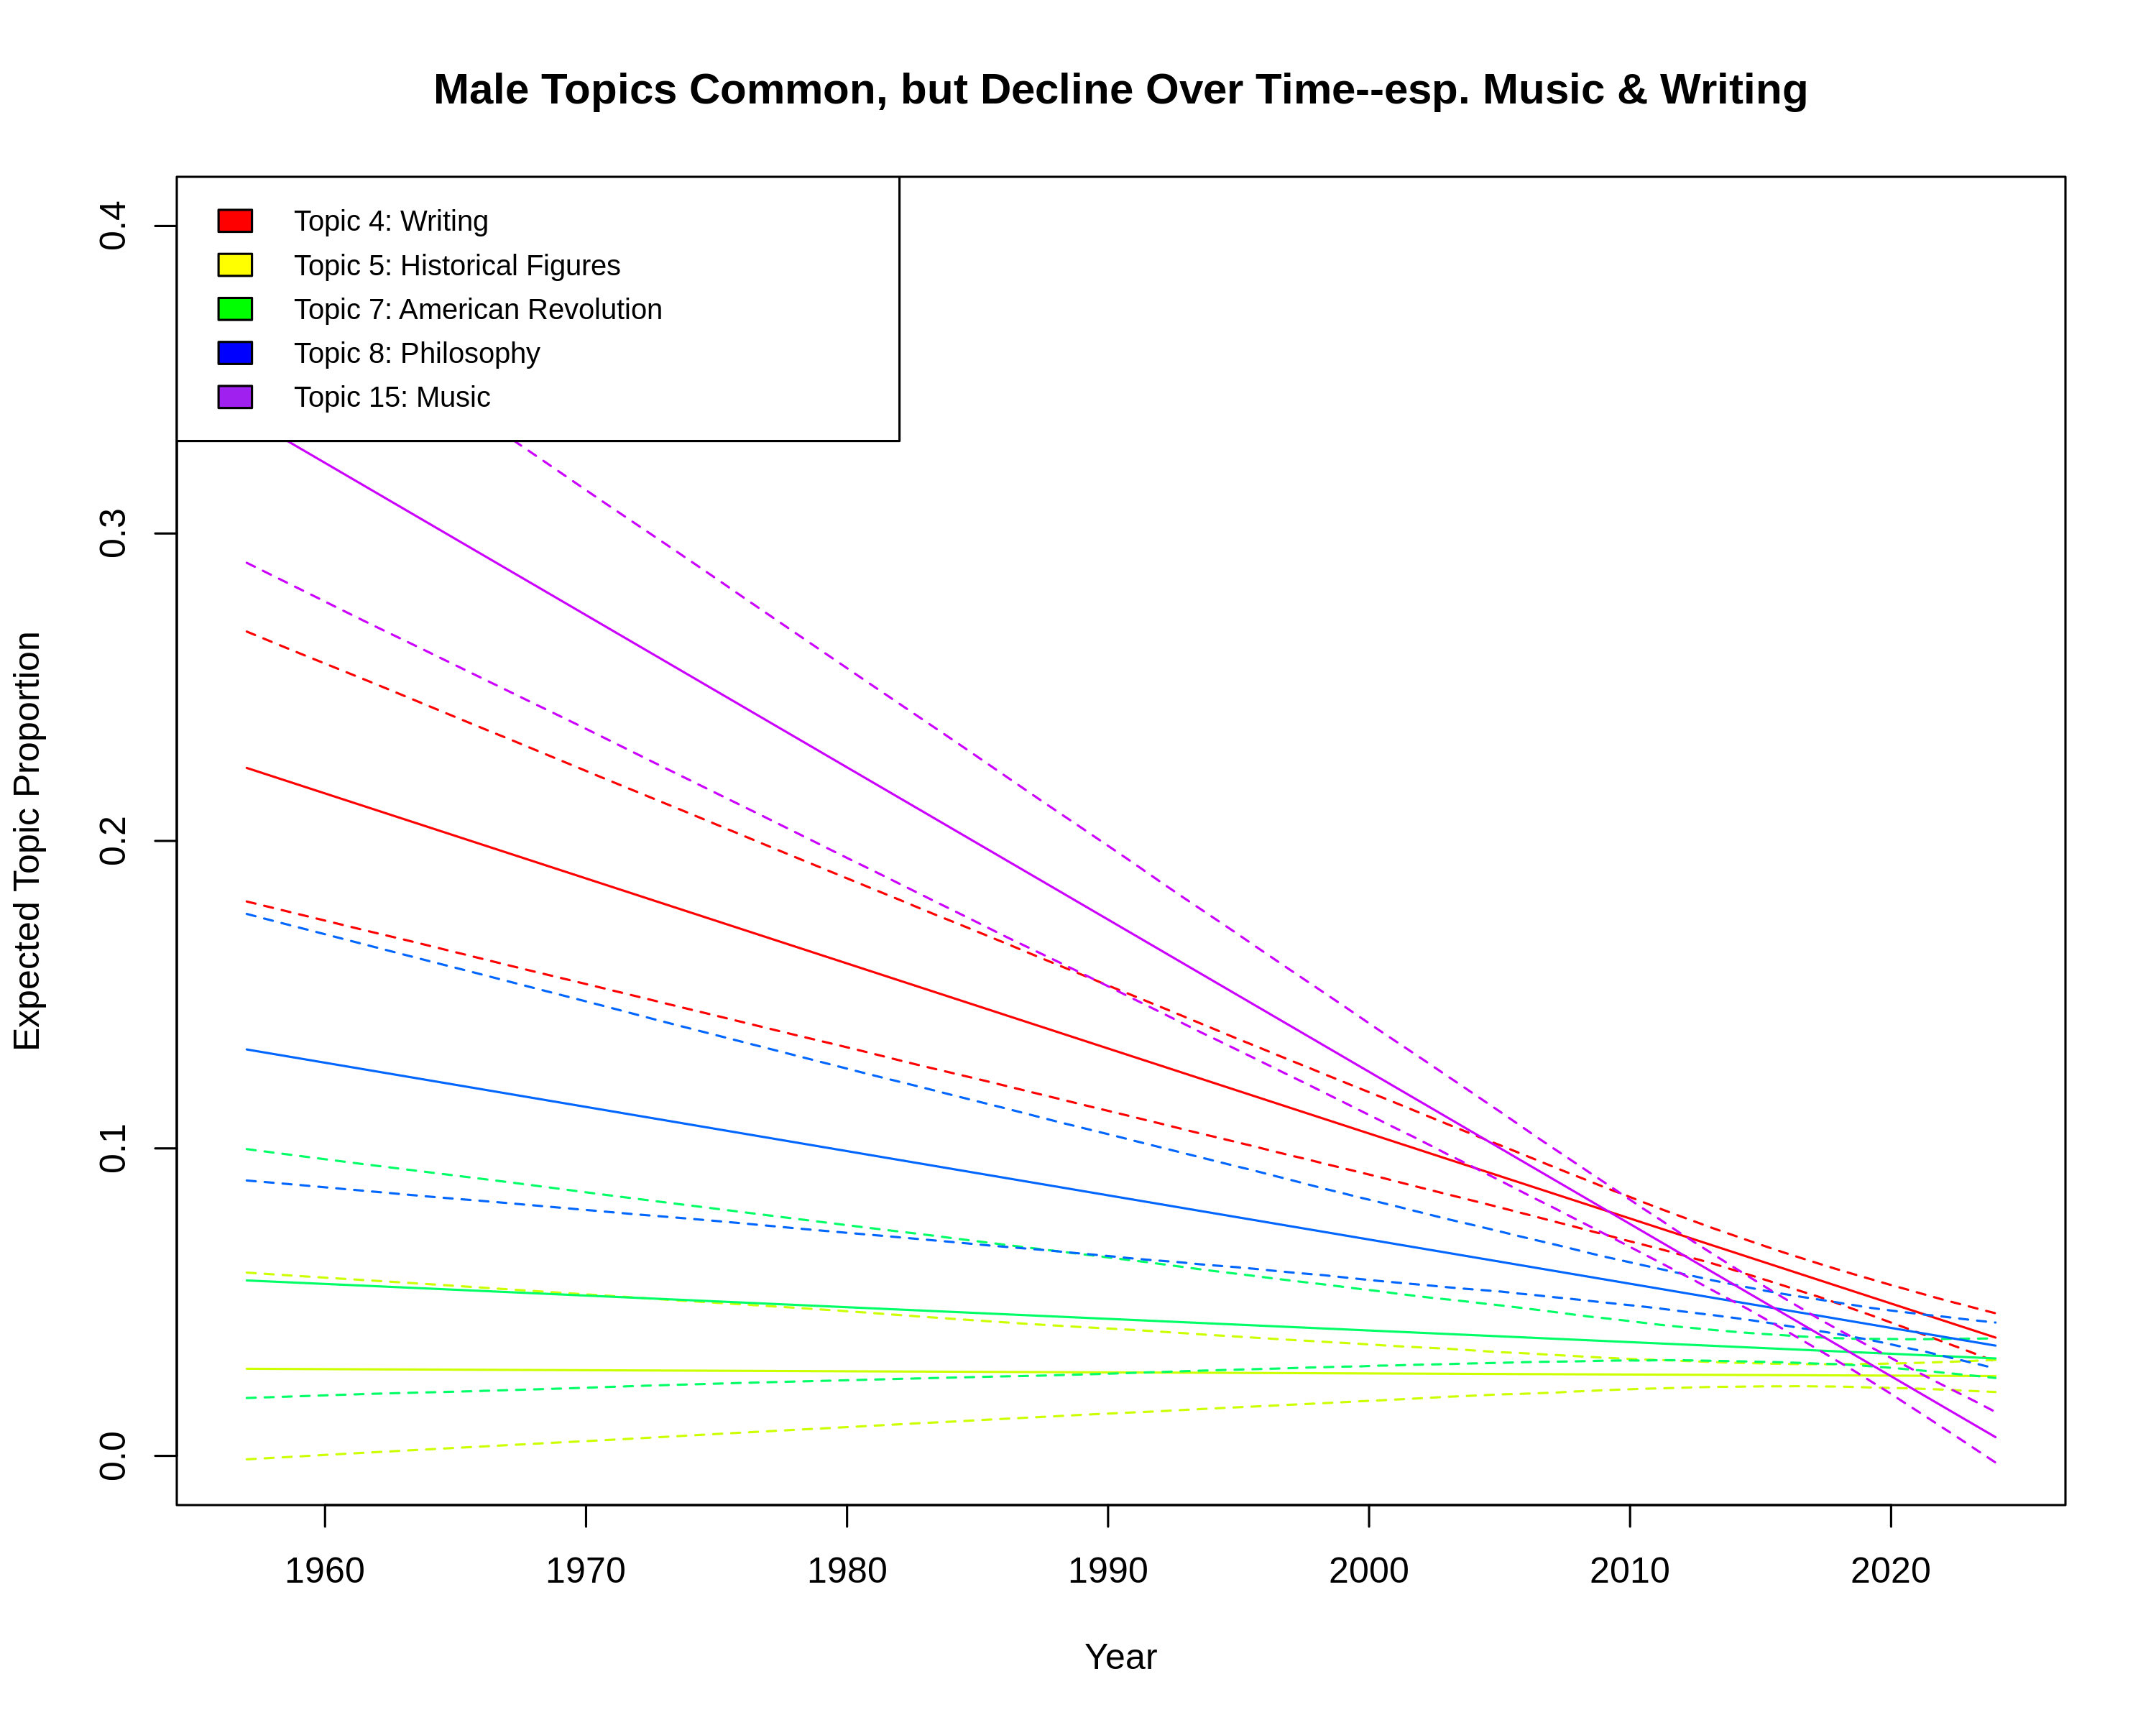

In [63]:
# Visualize topical prevalence over time for male-specific topics
title = "Male Topics Common, but Decline Over Time--esp. Music & Writing"
legend = c("Topic 4: Writing", "Topic 5: Historical Figures", 
           "Topic 7: American Revolution", "Topic 8: Philosophy", "Topic 15: Music")

# Show figure
plot(gender_effect, covariate="Year", topics=c(4, 5, 7, 8, 15), method="continuous", 
     model=model, xlab="Year", printlegend=FALSE, main=title, ylim = c(0, .4))
legend(x="topleft", legend=legend, fill=c("red", "yellow", "green", "blue", "purple"), cex=0.8)

# Save figure to disk
png(filename='../output/male_topics_over_time.png', width = 2000, height = 2000, units = "px", res = 300)
plot(gender_effect, covariate="Year", topics=c(4, 5, 7, 8, 15), method="continuous", 
     model=model, xlab="Year", printlegend=FALSE, main=title, ylim = c(0, .4))
legend(x="topleft", legend=legend, fill=c("red", "yellow", "green", "blue", "purple"), cex=0.8)
dev.off()

### Visualize using Loess Regression (very slow!)

In [ ]:
# Use Loess Regression to Visualize topical prevalence over time for male-specific topics
title = "Female Topics Rare, but Grow Over Time--Except Women's Studies"
legend = c("Topic 9: Civil War", "Topic 10: War", "Topic 12: Art", 
           "Topic 14: Urban Spaces", "Topic 20: Womens Studies")

# Show figure
plotTopicLoess(model, covariate=meta$Year, topics=c(9, 10, 12, 14, 20),
               xlab="Year", main=title)
legend(x="topleft", legend=legend, fill=c("red", "yellow", "green", "blue", "purple"), cex=0.8)

# Save figure to disk
png(filename='../output/female_topics_over_time_loess.png', width = 2000, height = 2000, units = "px", res = 300)
plotTopicLoess(model, covariate=meta$Year, topics=c(4, 5, 7, 8, 15),
               xlab="Year", main=title)
legend(x="topleft", legend=legend, fill=c("red", "yellow", "green", "blue", "purple"), cex=0.8)
dev.off()

In [ ]:
# Use Loess Regression to Visualize topical prevalence over time for male-specific topics
title = "Male Topics Common, but Decline Over Time--esp. Music & Writing"
legend = c("Topic 4: Writing", "Topic 5: Historical Figures", 
           "Topic 7: American Revolution", "Topic 8: Philosophy", "Topic 15: Music")

# Show figure
plotTopicLoess(model, covariate=meta$Year, topics=c(4, 5, 7, 8, 15),
               xlab="Year", main=title)
legend(x="topleft", legend=legend, fill=c("red", "yellow", "green", "blue", "purple"), cex=0.8)

# Save figure to disk
png(filename='../output/male_topics_over_time_loess.png', width = 2000, height = 2000, units = "px", res = 300)
plotTopicLoess(model, covariate=meta$Year, topics=c(4, 5, 7, 8, 15),
               xlab="Year", main=title)
legend(x="topleft", legend=legend, fill=c("red", "yellow", "green", "blue", "purple"), cex=0.8)
dev.off()